# Traffic Sign Classification with Keras

Keras exists to make coding deep neural networks simpler. To demonstrate just how easy it is, you’re going to use Keras to build a convolutional neural network in a few dozen lines of code.

You’ll be connecting the concepts from the previous lessons to the methods that Keras provides.

## Dataset

The network you'll build with Keras is similar to the example that you can find in Keras’s GitHub repository that builds out a [convolutional neural network for MNIST](https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py). 

However, instead of using the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, you're going to use the [German Traffic Sign Recognition Benchmark](http://benchmark.ini.rub.de/?section=gtsrb&subsection=news) dataset that you've used previously.

You can download pickle files with sanitized traffic sign data here.

## Overview

Here are the steps you'll take to build the network:

1. First load the training data and do a train/validation split.
2. Preprocess data.
3. Build a feedforward neural network to classify traffic signs.
4. Build a convolutional neural network to classify traffic signs.
5. Evaluate performance of final neural network on testing data.

Keep an eye on the network’s accuracy over time. Once the accuracy reaches the 98% range, you can be confident that you’ve built and trained an effective model.

In [1]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import math

## Load the Data

Start by importing the data from the pickle file.

In [2]:
# TODO: Implement load the data here.
with open('train.p', 'rb') as f:
    data = pickle.load(f)

## Validate the Network
Split the training data into a training and validation set.

Measure the [validation accuracy](https://keras.io/models/sequential/) of the network after two training epochs.

Hint: [Use the `train_test_split()` method](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) from scikit-learn.

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

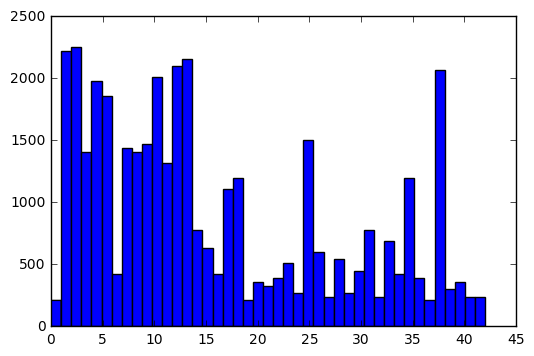

In [34]:
plt.hist(data['labels'], bins = 43);

In [49]:
from keras.utils import np_utils

X = data['features']
y = data['labels']


# TODO: Use `train_test_split` here.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, stratify = y )


In [50]:
y_val = np_utils.to_categorical(y_val, 43)
y_train = np_utils.to_categorical(y_train, 43)

In [51]:
# STOP: Do not change the tests below. Your implementation should pass these tests. 
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

## Preprocess the Data

Now that you've loaded the training data, preprocess the data such that it's in the range between -0.5 and 0.5.

In [52]:
# TODO: Implement data normalization here.
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_train = X_train / 255 - 0.5
X_val = X_val / 255 - 0.5

In [6]:
# STOP: Do not change the tests below. Your implementation should pass these tests. 
assert(math.isclose(np.min(X_train), -0.5, abs_tol=1e-5) and math.isclose(np.max(X_train), 0.5, abs_tol=1e-5)), "The range of the training data is: %.1f to %.1f" % (np.min(X_train), np.max(X_train))
assert(math.isclose(np.min(X_val), -0.5, abs_tol=1e-5) and math.isclose(np.max(X_val), 0.5, abs_tol=1e-5)), "The range of the validation data is: %.1f to %.1f" % (np.min(X_val), np.max(X_val))

## Build a Two-Layer Feedfoward Network

The code you've written so far is for data processing, not specific to Keras. Here you're going to build Keras-specific code.

Build a two-layer feedforward neural network, with 128 neurons in the fully-connected hidden layer. 

To get started, review the Keras documentation about [models](https://keras.io/models/sequential/) and [layers](https://keras.io/layers/core/).

The Keras example of a [Multi-Layer Perceptron](https://github.com/fchollet/keras/blob/master/examples/mnist_mlp.py) network is similar to what you need to do here. Use that as a guide, but keep in mind that there are a number of differences.

In [7]:
# TODO: Build a two-layer feedforward neural network with Keras here.
from keras.models import Sequential
from keras.layers import Dense, Input, Activation
from keras.callbacks import EarlyStopping
earlystop= EarlyStopping(min_delta= 0.008, patience= 1, verbose=1)


model1 = Sequential()
model1.add(Dense(128, activation='relu', input_shape=(32*32*3,)))
model1.add(Dense(43, activation='softmax'))

In [8]:
# STOP: Do not change the tests below. Your implementation should pass these tests.
dense_layers = []
for l in model1.layers:
    if type(l) == Dense:
        dense_layers.append(l)
assert(len(dense_layers) == 2), "There should be 2 Dense layers."
d1 = dense_layers[0]
d2 = dense_layers[1]
assert(d1.input_shape == (None, 3072))
assert(d1.output_shape == (None, 128))
assert(d2.input_shape == (None, 128))
assert(d2.output_shape == (None, 43))

last_layer = model1.layers[-1]
assert(last_layer.activation.__name__ == 'softmax'), "Last layer should be softmax activation, is {}.".format(last_layer.activation.__name__)

In [9]:
# Debugging
for l in model1.layers:
    print(l.name, l.input_shape, l.output_shape, l.activation)

dense_1 (None, 3072) (None, 128) <function relu at 0x12295fd90>
dense_2 (None, 128) (None, 43) <function softmax at 0x12295fb70>


## Train the Network
Compile and train the network for 2 epochs. [Use the `adam` optimizer, with `categorical_crossentropy` loss.](https://keras.io/models/sequential/)

Hint 1: In order to use categorical cross entropy, you will need to [one-hot encode the labels](https://github.com/fchollet/keras/blob/master/keras/utils/np_utils.py).

Hint 2: In order to pass the input images to the fully-connected hidden layer, you will need to [reshape the input](https://github.com/fchollet/keras/blob/master/examples/mnist_mlp.py).

Hint 3: Keras's `.fit()` method returns a `History.history` object, which the tests below use. Save that to a variable named `history`.

In [10]:
# TODO: Compile and train the model here.

X_train_flat = X_train.reshape(-1, 32*32*3)
X_val_flat = X_val.reshape(-1, 32*32*3)

model1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history1 = model1.fit(X_train_flat, y_train,
                    batch_size=128, nb_epoch=20,
                    verbose=1, validation_data=(X_val_flat, y_val), callbacks = [earlystop])


Train on 26270 samples, validate on 12939 samples
Epoch 1/20
26270/26270 [==============================] - 4s - loss: 1.9110 - acc: 0.5042 - val_loss: 1.1930 - val_acc: 0.6879
Epoch 2/20
26270/26270 [==============================] - 4s - loss: 0.9514 - acc: 0.7496 - val_loss: 0.8151 - val_acc: 0.7639
Epoch 3/20
26270/26270 [==============================] - 4s - loss: 0.6693 - acc: 0.8292 - val_loss: 0.7043 - val_acc: 0.7946
Epoch 4/20
26270/26270 [==============================] - 4s - loss: 0.5281 - acc: 0.8667 - val_loss: 0.5379 - val_acc: 0.8601
Epoch 5/20
26270/26270 [==============================] - 4s - loss: 0.4443 - acc: 0.8848 - val_loss: 0.4466 - val_acc: 0.8895
Epoch 6/20
26270/26270 [==============================] - 4s - loss: 0.3734 - acc: 0.9052 - val_loss: 0.4177 - val_acc: 0.8947
Epoch 7/20
26270/26270 [==============================] - 4s - loss: 0.3406 - acc: 0.9119 - val_loss: 0.4899 - val_acc: 0.8588
Epoch 8/20
26270/26270 [==============================] - 4s 

**Validation Accuracy**: (fill in here)

## Congratulations
You've built a feedforward neural network in Keras!

Don't stop here! Next, you'll add a convolutional layer to drive.py.

## Convolutions
Build a new network, similar to your existing network. Before the hidden layer, add a 3x3 [convolutional layer](https://keras.io/layers/convolutional/#convolution2d) with 32 filters and valid padding.

Then compile and train the network.

Hint 1: The Keras example of a [convolutional neural network](https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py) for MNIST would be a good example to review.

Hint 2: Now that the first layer of the network is a convolutional layer, you no longer need to reshape the input images before passing them to the network. You might need to reload your training data to recover the original shape.

Hint 3: Add a [`Flatten()` layer](https://keras.io/layers/core/#flatten) between the convolutional layer and the fully-connected hidden layer.

In [12]:
# TODO: Re-construct the network and add a convolutional layer before the first fully-connected layer.
from keras.layers import Conv2D, Flatten



In [53]:
model2 = Sequential()
model2.add(Conv2D(32, 3, 3, input_shape=(32, 32, 3), activation='relu'))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(43, activation='softmax'))

model2.summary()
# TODO: Compile and train the model here.
model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history2 = model2.fit(X_train, y_train,
                    batch_size=128, nb_epoch=20,
                    verbose=1, validation_data=(X_val, y_val), callbacks = [earlystop])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_6 (Convolution2D)  (None, 30, 30, 32)    896         convolution2d_input_6[0][0]      
____________________________________________________________________________________________________
flatten_6 (Flatten)              (None, 28800)         0           convolution2d_6[0][0]            
____________________________________________________________________________________________________
dense_13 (Dense)                 (None, 128)           3686528     flatten_6[0][0]                  
____________________________________________________________________________________________________
dense_14 (Dense)                 (None, 43)            5547        dense_13[0][0]                   
Total params: 3692971
_____________________________________________________________________

**Validation Accuracy**: (fill in here)

## Pooling
Re-construct your network and add a 2x2 [pooling layer](https://keras.io/layers/pooling/#maxpooling2d) immediately following your convolutional layer.

Then compile and train the network.

In [14]:
# TODO: Re-construct the network and add a pooling layer after the convolutional layer.
# TODO: Re-construct the network and add a pooling layer after the convolutional layer.
from keras.layers import Conv2D, Flatten, MaxPooling2D, Activation

In [16]:

model3 = Sequential()
model3.add(Conv2D(32, 3, 3, input_shape=(32, 32, 3)))
model3.add(MaxPooling2D((2,2)))
model3.add(Activation('relu'))
model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dense(43, activation='softmax'))

model3.summary()
# TODO: Compile and train the model here.
model3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history3 = model3.fit(X_train, y_train,
                    batch_size=128, nb_epoch=20,
                    verbose=1, validation_data=(X_val, y_val), callbacks = [earlystop])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_3 (Convolution2D)  (None, 30, 30, 32)    896         convolution2d_input_3[0][0]      
____________________________________________________________________________________________________
maxpooling2d_2 (MaxPooling2D)    (None, 15, 15, 32)    0           convolution2d_3[0][0]            
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 15, 15, 32)    0           maxpooling2d_2[0][0]             
____________________________________________________________________________________________________
flatten_3 (Flatten)              (None, 7200)          0           activation_2[0][0]               
___________________________________________________________________________________________

**Validation Accuracy**: (fill in here)

## Dropout
Re-construct your network and add [dropout](https://keras.io/layers/core/#dropout) after the pooling layer. Set the dropout rate to 50%.

In [17]:
# TODO: Re-construct the network and add dropout after the pooling layer.
from keras.layers import Dropout

In [18]:
model4 = Sequential()
model4.add(Conv2D(32, 3, 3, input_shape=(32, 32, 3)))
model4.add(MaxPooling2D((2,2)))
model4.add((Dropout(0.5)))
model4.add(Activation('relu'))
model4.add(Flatten())
model4.add(Dense(128, activation='relu'))
model4.add(Dense(43, activation='softmax'))

model4.summary()
# TODO: Compile and train the model here.
model4.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history4 = model4.fit(X_train, y_train,
                    batch_size=128, nb_epoch=20,
                    verbose=1, validation_data=(X_val, y_val), callbacks = [earlystop])
# TODO: Compile and train the model here.

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_4 (Convolution2D)  (None, 30, 30, 32)    896         convolution2d_input_4[0][0]      
____________________________________________________________________________________________________
maxpooling2d_3 (MaxPooling2D)    (None, 15, 15, 32)    0           convolution2d_4[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 15, 15, 32)    0           maxpooling2d_3[0][0]             
____________________________________________________________________________________________________
activation_3 (Activation)        (None, 15, 15, 32)    0           dropout_1[0][0]                  
___________________________________________________________________________________________

**Validation Accuracy**: (fill in here)

## Optimization
Congratulations! You've built a neural network with convolutions, pooling, dropout, and fully-connected layers, all in just a few lines of code.

Have fun with the model and see how well you can do! Add more layers, or regularization, or different padding, or batches, or more training epochs.

What is the best validation accuracy you can achieve?

In [19]:
history4.history

{'acc': [0.55866006853283701,
  0.85709935288307648,
  0.91834792535841392,
  0.93962695086279158,
  0.95458698131577979,
  0.96140083746171334,
  0.96547392459708925,
  0.97007993906225864,
  0.97236391320898363,
  0.97578987438142373,
  0.97883517317414326,
  0.98024362387383079],
 'loss': [1.6783720971333649,
  0.54136567103077715,
  0.32304962565565815,
  0.23411430820885112,
  0.1808397036033027,
  0.15133527495423604,
  0.13206270812444465,
  0.11241172612405431,
  0.10347644052123293,
  0.089924028176895154,
  0.078296346365157574,
  0.078172177112075275],
 'val_acc': [0.83383569054334916,
  0.9168405595486514,
  0.94551356366782779,
  0.96050699435814202,
  0.96344385192055026,
  0.97039956719993814,
  0.97186799598114226,
  0.97611871087410151,
  0.97580956797279539,
  0.98245614035087714,
  0.97959656851379551,
  0.97727799675399951],
 'val_loss': [0.72025304358325593,
  0.36842765778231745,
  0.23528518776905041,
  0.18059499518254393,
  0.16880654595116854,
  0.126852821601

**Best Validation Accuracy:** (fill in here)

## Testing
Once you've picked out your best model, it's time to test it.

Load up the test data and use the [`evaluate()` method](https://keras.io/models/model/#evaluate) to see how well it does.

Hint 1: The `evaluate()` method should return an array of numbers. Use the `metrics_names()` method to get the labels.

In [20]:
# TODO: Load test data
with open('./test.p', mode='rb') as f:
    test = pickle.load(f)
    
# TODO: Preprocess data & one-hot encode the labels
X_test = test['features']
y_test = test['labels']
X_test = X_test.astype('float32')
X_test /= 255
X_test -= 0.5
y_test = np_utils.to_categorical(y_test, 43)

# TODO: Evaluate model on test

In [23]:
X_test_flat = X_test.reshape(-1, 32*32*3)
model1.evaluate(X_test_flat, y_test)

12630/12630 [==============================] - 1s     


[0.86440105602463746, 0.76247030874140564]

In [54]:
model2.evaluate(X_test, y_test)

12630/12630 [==============================] - 10s    


[0.79371107594771506, 0.88083927161336795]

In [25]:
model3.evaluate(X_test, y_test)

12630/12630 [==============================] - 7s     


[0.69315784700975847, 0.87537608863999705]

In [26]:
model4.evaluate(X_test, y_test)

12630/12630 [==============================] - 8s     


[0.55205653501897223, 0.88669833732991588]

In [55]:
model3.metrics_names

['loss', 'acc']

**Test Accuracy:** (fill in here)

## Summary
Keras is a great tool to use if you want to quickly build a neural network and evaluate performance.

In [61]:
print (data['labels'].shape)

(39209,)


In [63]:
print (test['labels'].shape)

(12630,)


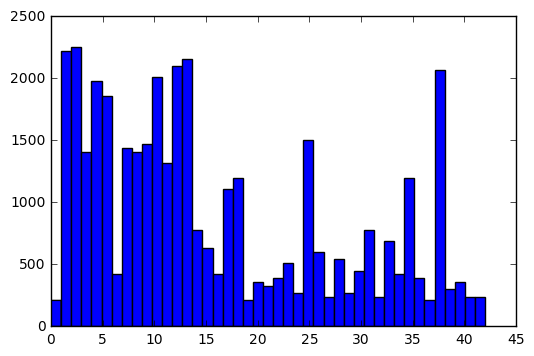

In [65]:
plt.hist(data['labels'], bins =43);

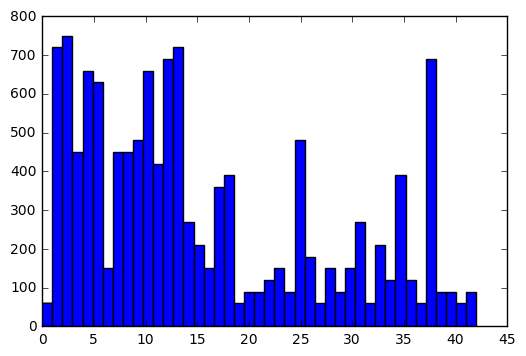

In [67]:
plt.hist(test['labels'], bins = 43);

In [68]:
print (type(data['features']))

<class 'numpy.ndarray'>


In [70]:
d = data['features']

In [71]:
type(d)


numpy.ndarray

In [73]:
d.shape

(39209, 32, 32, 3)

In [77]:
print ((d[:1].shape))

(1, 32, 32, 3)
